<a href="https://colab.research.google.com/github/samiraabnar/MI_Estimation/blob/master/MINE_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jax Implementation of [MINE: Mutual Information Neural Estimation](https://arxiv.org/abs/1801.04062)

The code here is based on this implementation: https://github.com/mzgubic/MINE

In [12]:
!pip install flax

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

import jax
from jax import numpy as jnp, random, jit, lax
import flax
from flax import nn, optim

from time import time

In [13]:
# data
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

data_size = 20000
x=gen_x()
y=gen_y(x)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
print(mi)
mi_numerical = mutual_info_regression(x.reshape(-1, 1), y.ravel())[0]
print(mi_numerical)

0.6573884112315902
0.6589340109221135


In [0]:
class MINE(nn.Module):
  """ Mutual Information Neural Estimation
      https://arxiv.org/abs/1801.04062
  """
  def apply(self, x_in, y_in):
    hidden_dim = 20
    output_dim = 1

    # Shuffle and concatenate
    rng = flax.nn.make_rng()
    y_shuffle = jax.random.permutation(rng, y_in)
    x_conc = jnp.concatenate([x_in, x_in], axis=0)
    y_conc = jnp.concatenate([y_in, y_shuffle], axis=0)

    # Linear transformations
    layer_x = nn.Dense(x_conc, hidden_dim, name='linear_x')
    layer_y = nn.Dense(y_conc, hidden_dim, name='linear_y')

    # Relu activation on the sum of the linear transformations
    h = nn.relu(layer_x + layer_y)

    # Final output
    output = nn.Dense(h, output_dim)

    return output


In [0]:
n_epochs = 400
data_size = 20000
rng = jax.random.PRNGKey(0)

rng, rng_init = jax.random.split(rng)
with nn.stochastic(rng):
  _, initial_params = MINE.init_by_shape(rng_init, [((data_size, 1), jnp.float64), ((data_size, 1), jnp.float64)])
  mine_model = flax.nn.Model(MINE, initial_params)

optimizer = flax.optim.Adam(learning_rate=0.1).create(mine_model)

@jax.jit
def loss(outputs, x_in):
  # split in T_xy and T_x_y predictions
  n_samples = x_in.shape[0]
  T_xy = outputs[:n_samples]
  T_x_y = outputs[n_samples:]
    
  # compute the negative loss (maximise loss == minimise -loss)
  neg_loss = -(jnp.mean(T_xy, axis=0) - jnp.log(jnp.mean(jnp.exp(T_x_y))))
  return neg_loss

@jax.jit
def train_step(optimizer, batch_x, batch_y, rng=None):
  def loss_fn(model):
    with nn.stochastic(rng):
      outputs = model(batch_x, batch_y)
      loss_value = jnp.mean(loss(outputs, batch_x))
    return loss_value

  loss_value, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)

  return loss_value, optimizer
  


In [0]:
# train
MIs = []
for epoch in range(n_epochs):
    # generate the data
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    
    loss_value, optimizer = train_step(optimizer, x_sample, y_sample, rng)
    # save the loss
    MIs.append(-loss_value)



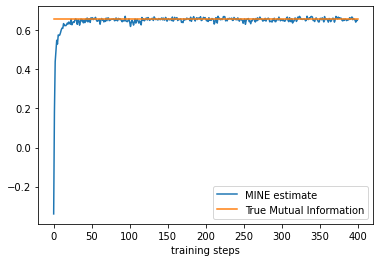

In [74]:
fig, ax = plt.subplots()
ax.plot(range(len(MIs)), MIs, label='MINE estimate')
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE.png')
fig.show()